In [1]:
import onnx
import onnxruntime as ort
import torch
import torchvision
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython import display
from matplotlib.animation import FuncAnimation

### Загрузка данных для обучения нейросети

In [2]:
with open('./tmp/inputs_sep.npy', 'rb') as f:
    inputs = np.load(f)
    inputs = inputs[50:200].astype('float32')
    
with open('./tmp/targets_sep.npy', 'rb') as f:
    targets = np.load(f)
    targets = targets[50:200].astype('float32')

In [3]:
inputs.shape, targets.shape

((150, 60), (150, 800))

In [4]:
timeline_len = targets.shape[0]

In [5]:
in_dim = inputs.shape[1]
out_dim = targets.shape[1]

In [6]:
inputs_tn = torch.from_numpy(inputs)
targets_tn = torch.from_numpy(targets)

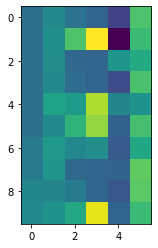

In [7]:
plt.imshow(inputs[0].reshape(10, 6)) 

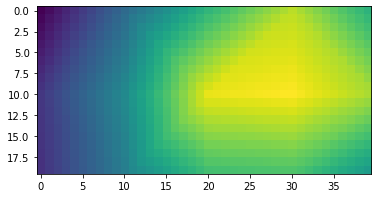

In [8]:
plt.imshow(targets[0].reshape(20, 40)) 

### Дизайн архитектуры нейросети

In [9]:
class AE(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=256
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=256, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=kwargs["output_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

### Инициализация и обучение

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AE(input_shape=in_dim, output_shape=out_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.MSELoss()

epochs = 25

In [11]:
dataset = torch.utils.data.TensorDataset(inputs_tn, targets_tn)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

In [12]:
for epoch in range(epochs):
    loss = 0
    for batch_inputs, batch_targets in loader:

        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(batch_inputs)
        
        train_loss = criterion(outputs, batch_targets)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(loader)
    
    if epoch % 5 == 0:
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/25, loss = 0.500796
epoch : 6/25, loss = 0.228837
epoch : 11/25, loss = 0.166552
epoch : 16/25, loss = 0.178492
epoch : 21/25, loss = 0.131915


### Визуализация предсказания нейросети 

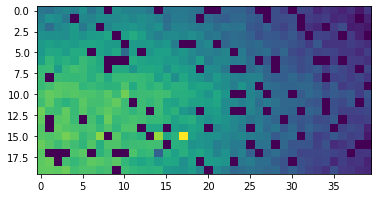

In [13]:
with torch.no_grad():
     rec_img  = model(inputs_tn[130])
        
plt.imshow(rec_img.numpy().reshape(20, 40)) 

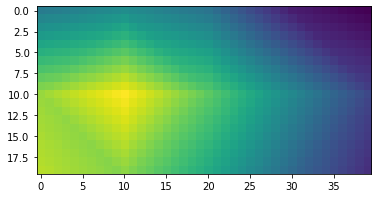

In [14]:
plt.imshow(targets[130].reshape(20, 40)) 

In [15]:
fig = plt.figure()

with torch.no_grad():
     rec_img  = model(inputs_tn[0])

im = plt.imshow(rec_img.numpy().reshape(20, 40), animated=True)

def updatefig(frame):
    global x, y
    with torch.no_grad():
         rec_img  = model(inputs_tn[frame])
    im.set_array(rec_img.numpy().reshape(20, 40))
    return im,

anim_created = FuncAnimation(fig, updatefig, frames=timeline_len, interval=50)    

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()
#anim_created.save('./tmp/CO_conc_estimation_sep.gif')

In [16]:
fig = plt.figure()


im = plt.imshow(targets[0].reshape(20, 40), animated=True)

def updatefig(frame):
    im.set_array(targets[frame].reshape(20, 40))
    return im,

anim_created = animation.FuncAnimation(fig, updatefig, frames=timeline_len, interval=50)    

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()
#anim_created.save('./tmp/CO_conc_sep.gif')

### Сохранение результатов работы нейросети 

In [17]:
with torch.no_grad():
    preds = model(inputs_tn).numpy()
          
with open('./tmp/prediction_sep.npy', 'wb') as f:
    np.save(f, preds) 

### Сохранение нейросети 

In [18]:
model_path = '../models/estimator/ae_model.onnx'
dummy_input = torch.randn(60, device='cpu')

In [19]:
input_names = ['input1']
output_names = ['output1']
torch.onnx.export(model, dummy_input, model_path, verbose=True, input_names=input_names, output_names=output_names)

graph(%input1 : Float(60, strides=[1], requires_grad=0, device=cpu),
      %encoder_hidden_layer.bias : Float(128, strides=[1], requires_grad=1, device=cpu),
      %encoder_output_layer.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %decoder_hidden_layer.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %decoder_output_layer.bias : Float(800, strides=[1], requires_grad=1, device=cpu),
      %25 : Float(60, 128, strides=[1, 60], requires_grad=0, device=cpu),
      %26 : Float(128, 256, strides=[1, 128], requires_grad=0, device=cpu),
      %27 : Float(256, 256, strides=[1, 256], requires_grad=0, device=cpu),
      %28 : Float(256, 800, strides=[1, 256], requires_grad=0, device=cpu)):
  %10 : Float(128, strides=[1], device=cpu) = onnx::MatMul(%input1, %25)
  %11 : Float(128, strides=[1], requires_grad=1, device=cpu) = onnx::Add(%encoder_hidden_layer.bias, %10) # /Users/vprud/Work/air_tracer/venv/lib/python3.7/site-packages/torch/nn/functional.py:1847:0

### Проверка корректности сохранения нейросети

In [20]:
model = onnx.load(model_path)

onnx.checker.check_model(model)

print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %input1[FLOAT, 60]
) initializers (
  %encoder_hidden_layer.bias[FLOAT, 128]
  %encoder_output_layer.bias[FLOAT, 256]
  %decoder_hidden_layer.bias[FLOAT, 256]
  %decoder_output_layer.bias[FLOAT, 800]
  %25[FLOAT, 60x128]
  %26[FLOAT, 128x256]
  %27[FLOAT, 256x256]
  %28[FLOAT, 256x800]
) {
  %10 = MatMul(%input1, %25)
  %11 = Add(%encoder_hidden_layer.bias, %10)
  %12 = Relu(%11)
  %14 = MatMul(%12, %26)
  %15 = Add(%encoder_output_layer.bias, %14)
  %16 = Relu(%15)
  %18 = MatMul(%16, %27)
  %19 = Add(%decoder_hidden_layer.bias, %18)
  %20 = Relu(%19)
  %22 = MatMul(%20, %28)
  %23 = Add(%decoder_output_layer.bias, %22)
  %output1 = Relu(%23)
  return %output1
}


In [21]:
ort_session = ort.InferenceSession(model_path)

outputs = ort_session.run(
    None,
    {"input1": np.random.randn(60).astype(np.float32)},
)
print(outputs[0])

[0.20724314 0.18912025 0.24113679 0.29359448 0.23968259 0.25937504
 0.25848484 0.28780234 0.         0.29056787 0.28573185 0.2809548
 0.28666863 0.27301514 0.         0.2572747  0.29837713 0.25788963
 0.24262759 0.23784369 0.         0.         0.23911865 0.23702574
 0.21225111 0.2221281  0.         0.         0.17350763 0.15476462
 0.         0.15082109 0.18455938 0.08837596 0.10528628 0.10218124
 0.03782734 0.08235674 0.06042415 0.12954344 0.24923208 0.29318333
 0.27043834 0.25323695 0.         0.2647192  0.2940527  0.34366974
 0.30113393 0.31165558 0.36163208 0.31111833 0.3373503  0.31588
 0.32781082 0.2935785  0.31579813 0.30682212 0.27391854 0.
 0.32019436 0.25815475 0.1948     0.2744403  0.26220214 0.21957268
 0.23236844 0.         0.23817974 0.18270487 0.21581368 0.
 0.11967459 0.11375456 0.13745952 0.09343994 0.07977188 0.04646514
 0.         0.06275387 0.23998325 0.24154703 0.24929899 0.31317198
 0.32187384 0.2466553  0.30957726 0.         0.30918443 0.34998313
 0.2982601  0.3

## 